In [284]:
# import packages

import pandas as pd
import numpy as np
import re
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb   
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
import pickle
from sklearn.model_selection import RandomizedSearchCV, KFold
import networkx as nx

# Model Prediction Task I

Since my colleagues' local devices do not have GPU access, there are two main approaches: (1) online platform able to host and run code like AWS / Google Colab / Virtual Machine, and (2) using predictive algorithms that are optimised for CPU and handles large datasets efficiently like LightGBM and Ridge/Lasso Regression. These models can be saved as pickle files to be used by my colleague so the models are ready to be used. Regardless of the platform used to store the code as it depends on budget, the algorithms chosen should be not just space efficient, but scalable and fast.

LightGBM
- fast, memory efficient and scalable - ideal for large datasets and real-time applications
- native support for categorical features without requiring one-hot encoding, improving efficiency and reducing memory space
- prone to overfitting and less interpretable than XGBoost due to leaf-wise tree growth stragtegy

Ridge Regression
- fast computation for moderately sized datasets without loss of performance or accuracy
- once the model has been trained on our large dataset and saved as a pickle file, assuming the predictor model will be used periodically, the dataset should not be so big that Ridge Regression is unable to handle with just a local CPU
- handles high-dimensional data well by introducing a penalty term to the loss function which regularizes the coefficient estimates

Lasso Regression
- computationally efficient and can be trained on a standard CPU
- handles high-dimensional data well by performing variable selection by shrinking some coefficients to 0, leading to more interpretable models

### Create Combined Dataset 

In [4]:
approval_1990_1999 = pd.read_csv("data/resale-flat-prices-based-on-approval-date-1990-1999.csv")
approval_2000_2012 = pd.read_csv("data/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv")
registration_2012_2014 = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv")
registration_2015_2016 = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv")
registration_2017 = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

In [5]:
print(f"resale-flat-prices-based-on-approval-date-1990-1999 with shape {approval_1990_1999.shape}\n", approval_1990_1999.head())
print(f"\nresale-flat-prices-based-on-approval-date-2000-feb-2012 {approval_2000_2012.shape}\n", approval_2000_2012.head())

resale-flat-prices-based-on-approval-date-1990-1999 with shape (287200, 10)
      month        town flat_type block       street_name storey_range  \
0  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
1  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     04 TO 06   
2  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
3  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     07 TO 09   
4  1990-01  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     04 TO 06   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  
0            31.0        IMPROVED                 1977          9000  
1            31.0        IMPROVED                 1977          6000  
2            31.0        IMPROVED                 1977          8000  
3            31.0        IMPROVED                 1977          6000  
4            73.0  NEW GENERATION                 1976         47200  

resale-flat-prices-based-on-approval-date-2000-feb-2012 (

In [6]:
print(f"resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014 with shape {registration_2012_2014.shape}\n", registration_2012_2014.head())
print(f"\nresale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016 {registration_2015_2016.shape}\n", registration_2015_2016.head())
print(f"\nresale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv {registration_2017.shape}\n", registration_2017.head())

resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014 with shape (52203, 10)
      month        town flat_type block        street_name storey_range  \
0  2012-03  ANG MO KIO    2 ROOM   172   ANG MO KIO AVE 4     06 TO 10   
1  2012-03  ANG MO KIO    2 ROOM   510   ANG MO KIO AVE 8     01 TO 05   
2  2012-03  ANG MO KIO    3 ROOM   610   ANG MO KIO AVE 4     06 TO 10   
3  2012-03  ANG MO KIO    3 ROOM   474  ANG MO KIO AVE 10     01 TO 05   
4  2012-03  ANG MO KIO    3 ROOM   604   ANG MO KIO AVE 5     06 TO 10   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  
0            45.0        Improved                 1986      250000.0  
1            44.0        Improved                 1980      265000.0  
2            68.0  New Generation                 1980      315000.0  
3            67.0  New Generation                 1984      320000.0  
4            67.0  New Generation                 1980      321000.0  

resale-flat-prices-based-on-regi

Upon reading the names of the 5 csv files, there are two distinct naming for datasets: approval and registration. However, given that approval ranges from 1990 to february 2012 and registration ranges from march 2012 and onwards, it seems more like a change in naming convention than completely different datasets given that the variables are mostly identical. The assumption is therefore that these 5 datasets are actually tracking the exact same thing, and thus can be combined into one full dataset.

However, there is some data manipulation required as the variable input data types and value styles differ across the years (i.e. datasets), with some datasets even having new variables. A deeper analysis of the differences between datasets to be combined will be conducted to determine the final dataset data types and standardisation of variables.

#### storey_range

It seems that the storey_range is in 3s. However, in registration_2012_2014, 6838 ranges are incorrect:

| storey_range      | Count |
| :---        |    :----:   |
| 01 TO 05 | 2700 |
| 06 TO 10 | 2474 |
| 11 TO 15 | 1259 |
| 16 TO 20 | 265 |
| 21 TO 25 | 92 |
| 26 TO 30 | 39 |
| 31 TO 35 | 2 |
| 36 TO 40 | 7 |

Since they cannot be changed to the predefined storey_ranges as below, they will be removed as including them will likely confuse the prediction model since it blurs the boundary between classes. 6838 out of 52203 (~13%) will be removed.

| storey_range      |
| :---        | 
|01 TO 03  |  
|04 TO 06  |  
|07 TO 09  |  
|10 TO 12  |  
|13 TO 15  |  
|16 TO 18  |  
|19 TO 21  |   
|22 TO 24  |   
|25 TO 27  |   
|28 TO 30  |   
|31 TO 33  |    
|34 TO 36  |    
|37 TO 39  |    
|40 TO 42  |    
|43 TO 45  |     
|46 TO 48 |      
|49 TO 51|       


In [7]:
approval_1990_1999["storey_range"].value_counts().sort_index()

storey_range
01 TO 03    60966
04 TO 06    75455
07 TO 09    69394
10 TO 12    58444
13 TO 15    13692
16 TO 18     4391
19 TO 21     2609
22 TO 24     1713
25 TO 27      536
Name: count, dtype: int64

In [8]:
approval_2000_2012["storey_range"].value_counts().sort_index()

storey_range
01 TO 03    76806
04 TO 06    95136
07 TO 09    84673
10 TO 12    71215
13 TO 15    24521
16 TO 18     9018
19 TO 21     4209
22 TO 24     2521
25 TO 27     1032
28 TO 30      434
31 TO 33       31
34 TO 36       20
37 TO 39       23
40 TO 42       12
Name: count, dtype: int64

In [9]:
registration_2012_2014["storey_range"].value_counts().sort_index()

storey_range
01 TO 03     9692
01 TO 05     2700
04 TO 06    11456
06 TO 10     2474
07 TO 09     9878
10 TO 12     8370
11 TO 15     1259
13 TO 15     3304
16 TO 18     1319
16 TO 20      265
19 TO 21      605
21 TO 25       92
22 TO 24      351
25 TO 27      183
26 TO 30       39
28 TO 30      115
31 TO 33       23
31 TO 35        2
34 TO 36       32
36 TO 40        7
37 TO 39       26
40 TO 42       11
Name: count, dtype: int64

In [10]:
registration_2015_2016["storey_range"].value_counts().sort_index()

storey_range
01 TO 03    7050
04 TO 06    8961
07 TO 09    8220
10 TO 12    7048
13 TO 15    3176
16 TO 18    1300
19 TO 21     514
22 TO 24     369
25 TO 27     189
28 TO 30     119
31 TO 33      53
34 TO 36      55
37 TO 39      54
40 TO 42      27
43 TO 45       8
46 TO 48       8
49 TO 51       2
Name: count, dtype: int64

In [11]:
registration_2017["storey_range"].value_counts().sort_index()

storey_range
01 TO 03    14471
04 TO 06    18697
07 TO 09    16944
10 TO 12    15173
13 TO 15     7519
16 TO 18     3421
19 TO 21     1485
22 TO 24     1099
25 TO 27      604
28 TO 30      381
31 TO 33      158
34 TO 36      160
37 TO 39      152
40 TO 42       82
43 TO 45        8
46 TO 48       13
49 TO 51        7
Name: count, dtype: int64

#### data types

In [12]:
"""
Input: <list<DataFrame>> list of dataframes
Description: returns each variable's datatype
Output: <DataFrame> dataframe comparing variables and datatypes
"""


def get_datatypes(dfs, df_names) :
    
    df_datatypes = pd.DataFrame()
    for i in range(len(dfs)) :
        df = dfs[i]
        df_name = df_names[i]
        col_datatypes = {}
        for col in df.columns :
            col_datatypes[col] = [type(df[col][0])]
        col_df = pd.DataFrame.from_dict(col_datatypes, orient='index').reset_index()
        col_df.columns = ["variable", f"data type_{df_name}"]
        if i == 0 :
            df_datatypes = col_df
        else :
            df_datatypes = df_datatypes.merge(col_df, on='variable', how='outer')


    return df_datatypes


In [13]:
dfs = [approval_1990_1999, approval_2000_2012, registration_2012_2014, registration_2015_2016, registration_2017]
get_datatypes(dfs, ["1990_1999", "2000_2012", "2012_2014", "2015_2016", "2017"])

,variable,data type_1990_1999,data type_2000_2012,data type_2012_2014,data type_2015_2016,data type_2017
0,block,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
1,flat_model,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
2,flat_type,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
3,floor_area_sqm,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>
4,lease_commence_date,<class 'numpy.int64'>,<class 'numpy.int64'>,<class 'numpy.int64'>,<class 'numpy.int64'>,<class 'numpy.int64'>
5,month,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
6,remaining_lease,NaN,NaN,NaN,<class 'numpy.int64'>,<class 'str'>
7,resale_price,<class 'numpy.int64'>,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>
8,storey_range,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
9,street_name,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>


all 5 datasets have the same datatypes for block, flat_model, flat_type, floor_area_sqm, lease_commence_date, month, storey range, street_name and town. For resale_price, 1990_1999 is only one using int64 while from 2000, float is used. Assuming this datatype input change happened starting from 2000, resale_price in 1990_1999 will be changed to float as well for consistency. For remaining_lease, it seems like it was only created after 2015, explaining why this variable did not exist from 1990 to 2014. However, 2017 onwards uses string to include months while 2015_2016 uses int64, only taking the number of years. To capture the true value of remaining_lease, we will maintain the datatype int64 and convert values into months instead. For flat_model, 1990_1999 capitalises all variable inputs while the other datasets did not. To standardise, flat_model will all be capitalised for ease later when encoding categorical variables.

In [14]:
"""
Input: <str> remaining_lease value (e.g. 61 years 04 months)
Description: parses a string and converts years and months into only months
Output: <int> number of months
"""
def convert_to_total_months(lease_str):
    if not isinstance(lease_str, str):
        return 0
    
    # Extract digit for years and digit for months
    years_match = re.search(r'(\d+)\s*years?', lease_str)
    months_match = re.search(r'(\d+)\s*months?', lease_str)
    
    years = int(years_match.group(1)) if years_match else 0
    months = int(months_match.group(1)) if months_match else 0
    
    return (years * 12) + months

In [15]:
"""
Input: <DataFrame> dataframes to be combined
Description:
    - change approval_1990_1999 resale_price datatype to float
    - remove registration_2012_2014 incorrect storey_ranges
    - capitalise flat_model
    - convert remaining_lease to months
Output: <DataFrame> combined dataframe
"""

def create_df(approval_1990_1999, approval_2000_2012, registration_2012_2014, registration_2015_2016, registration_2017) :
    
    # change approval_1990_1999 resale_price datatype
    approval_1990_1999["resale_price"] = approval_1990_1999["resale_price"].astype(float)

    # remove registration_2012_2014 incorrect storey_ranges
    remove_storey_ranges = ["01 TO 05", "06 TO 10", "11 TO 15", "16 TO 20", "21 TO 25", "26 TO 30", "31 TO 35", "36 TO 40"]
    registration_2012_2014 = registration_2012_2014.loc[~registration_2012_2014["storey_range"].isin(remove_storey_ranges)].reset_index(drop=True)
    
    # convert remaining_lease to months
    registration_2015_2016["remaining_lease"] = registration_2015_2016["remaining_lease"]*12
    registration_2017['remaining_lease'] = registration_2017['remaining_lease'].apply(convert_to_total_months)

    # create df
    df = pd.concat([approval_1990_1999, approval_2000_2012, registration_2012_2014, registration_2015_2016, registration_2017])
    
    # capitalise flat_model
    df["flat_model"] = df["flat_model"].str.upper()

    df = df.reset_index(drop=True)
    
    return df

In [51]:
df = create_df(approval_1990_1999, approval_2000_2012, registration_2012_2014, registration_2015_2016, registration_2017)
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
819738,2020-09,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,IMPROVED,1987,440000.0,0.0
819739,2020-09,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,IMPROVED,1987,458000.0,0.0
819740,2020-09,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122.0,IMPROVED,1987,490000.0,0.0
819741,2020-09,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146.0,MAISONETTE,1987,558000.0,0.0


### Exploratory Data Analysis

#### Duplicates
The 1843 duplicates will not be dropped because there is no unique identifier, it could so happen that multiple units in a storey_range were sold in the exact same block and street_name.

In [17]:
df.shape[0]-df.drop_duplicates().shape[0]

1815

#### Missing Values

The dataset is mostly intact, with the only null values coming from remaining_lease as it was only recorded from 2015 and confirmed by checking no null values from 2015.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819743 entries, 0 to 819742
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                819743 non-null  object 
 1   town                 819743 non-null  object 
 2   flat_type            819743 non-null  object 
 3   block                819743 non-null  object 
 4   street_name          819743 non-null  object 
 5   storey_range         819743 non-null  object 
 6   floor_area_sqm       819743 non-null  float64
 7   flat_model           819743 non-null  object 
 8   lease_commence_date  819743 non-null  int64  
 9   resale_price         819743 non-null  float64
 10  remaining_lease      117527 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 68.8+ MB


In [19]:
registration_2015_2016.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37153 entries, 0 to 37152
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                37153 non-null  object 
 1   town                 37153 non-null  object 
 2   flat_type            37153 non-null  object 
 3   block                37153 non-null  object 
 4   street_name          37153 non-null  object 
 5   storey_range         37153 non-null  object 
 6   floor_area_sqm       37153 non-null  float64
 7   flat_model           37153 non-null  object 
 8   lease_commence_date  37153 non-null  int64  
 9   remaining_lease      37153 non-null  int64  
 10  resale_price         37153 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 3.1+ MB


In [20]:
registration_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80374 entries, 0 to 80373
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                80374 non-null  object 
 1   town                 80374 non-null  object 
 2   flat_type            80374 non-null  object 
 3   block                80374 non-null  object 
 4   street_name          80374 non-null  object 
 5   storey_range         80374 non-null  object 
 6   floor_area_sqm       80374 non-null  float64
 7   flat_model           80374 non-null  object 
 8   lease_commence_date  80374 non-null  int64  
 9   remaining_lease      80374 non-null  int64  
 10  resale_price         80374 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 6.7+ MB


#### Outliers

Box plots will be used to identify outliers as interquartile range is robust to outliers and does not assume a specific distribution unlike Z-score. Even though there are many properties with floor_area_sqm and resale_price above the third quartile, it is likely due to the big range of property sizes and thus prices. 

Text(0.5, 1.0, 'Box Plot for floor_area_sqm')

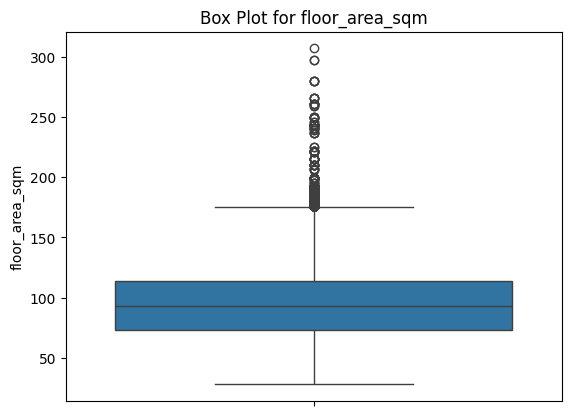

In [21]:
ax = sns.boxplot(y=df["floor_area_sqm"].dropna())
ax.set_title("Box Plot for floor_area_sqm")

Text(0.5, 1.0, 'Box Plot for resale_price')

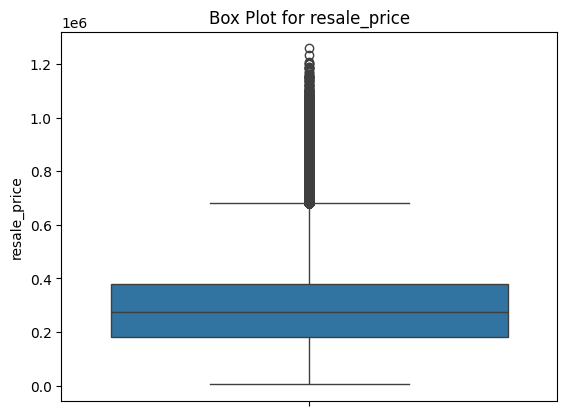

In [22]:
ax = sns.boxplot(y=df["resale_price"].dropna())
ax.set_title("Box Plot for resale_price")

Text(0.5, 1.0, 'Box Plot for remaining_lease')

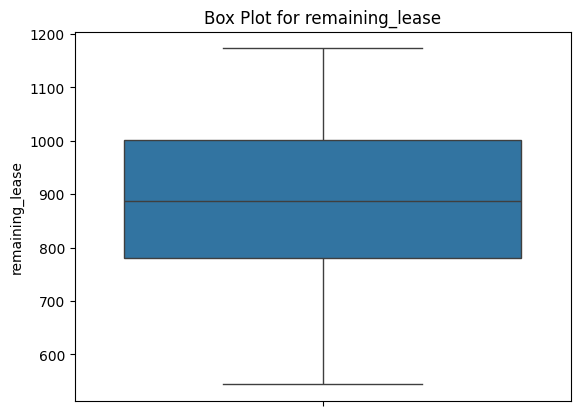

In [23]:
ax = sns.boxplot(y=df["remaining_lease"].dropna())
ax.set_title("Box Plot for remaining_lease")

#### month

By using seasonal decompose, we can see that there is seasonality - periodic fluctuations that repeat at regular intervals.

Text(0.5, 1.0, 'Number of houses sold per month from 1990 to 2020')

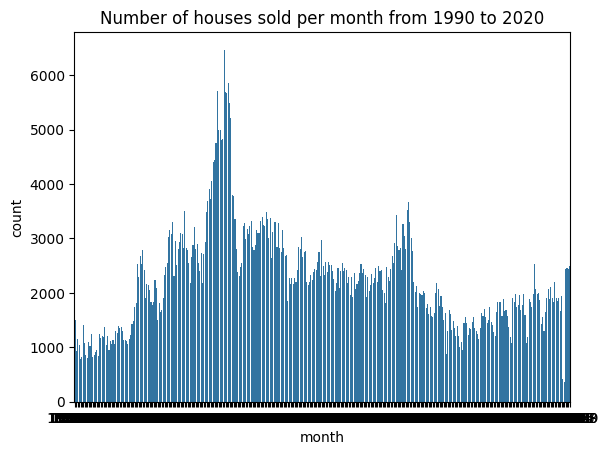

In [168]:
data = df.groupby('month').size().reset_index(name='count')
ax = sns.barplot(x="month", y="count", data=data)
ax.set_title("Number of houses sold per month from 1990 to 2020")

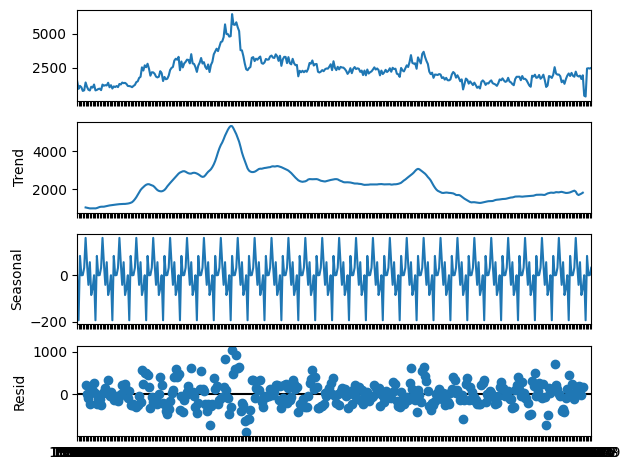

In [285]:
ts = data.set_index('month')
result = seasonal_decompose(ts, model='additive', period=12)
result.plot()
plt.show()

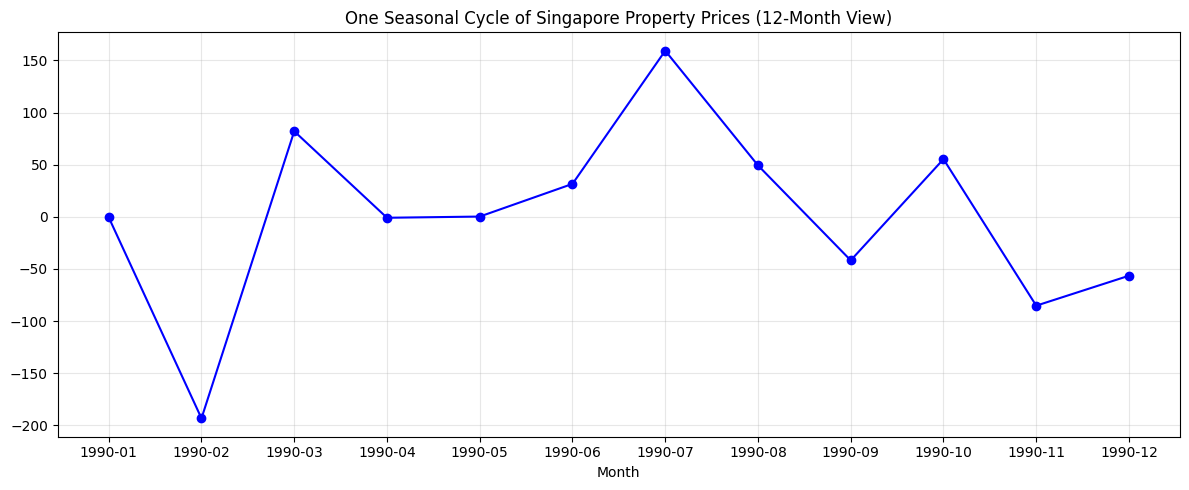

In [286]:
seasonal_component = result.seasonal
one_cycle = seasonal_component[:12]
plt.figure(figsize=(12, 5))
plt.plot(one_cycle.index, one_cycle.values, marker='o', linestyle='-', color='b')
plt.title('One Seasonal Cycle of Singapore Property Prices (12-Month View)')
plt.xlabel('Month')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### town

Some towns are more popular than others and have different maximum resale_prices by town.

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1062/1891525427.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


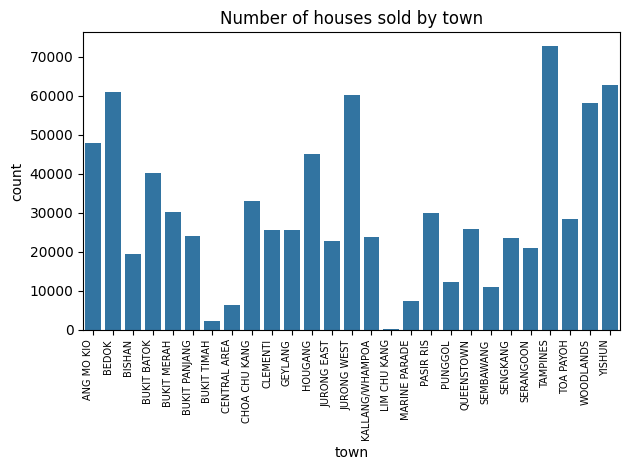

In [26]:
data = df.groupby('town').size().reset_index(name='count').sort_values("town")
ax = sns.barplot(y="count", x="town", data=data, legend=True)
ax.set_title("Number of houses sold by town")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1062/2395755033.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


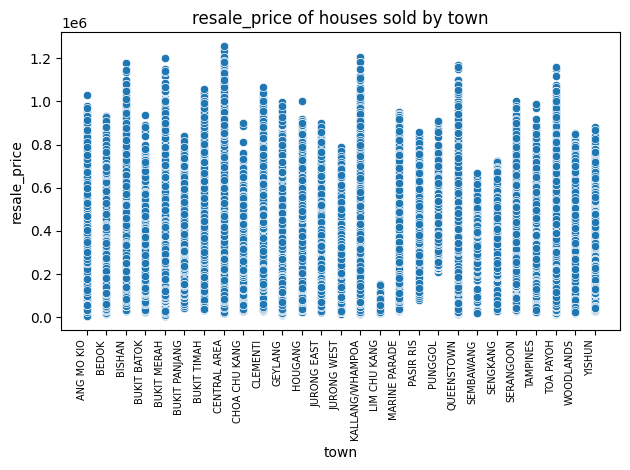

In [27]:
ax = sns.scatterplot(y="resale_price", x="town", data=df.sort_values("town"), legend=True)
ax.set_title("resale_price of houses sold by town")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

#### storey_range

Lower floors are sold more, but they also have the lower starting resale_prices compared to higher floors.

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1062/3300989319.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


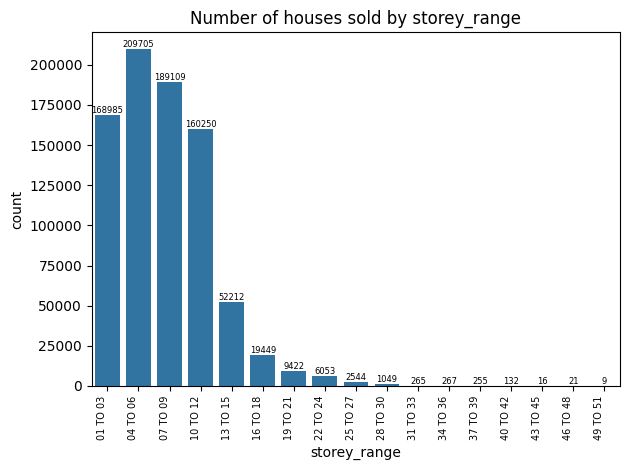

In [28]:
data = df.groupby('storey_range').size().reset_index(name='count')
ax = sns.barplot(y="count", x="storey_range", data=data, legend=True)
for container in ax.containers:
    ax.bar_label(container, fontsize=6)
ax.set_title("Number of houses sold by storey_range")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1062/525765342.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


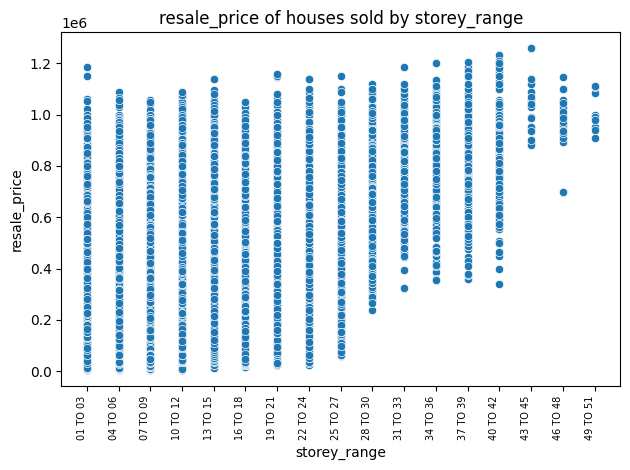

In [29]:
ax = sns.scatterplot(y="resale_price", x="storey_range", data=df.sort_values("storey_range"), legend=True)
ax.set_title("resale_price of houses sold by storey_range")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

#### floor_area_sqm

For lower floor_area_sqm, resale_price is almost guaranteed to be lower. However, for higher floor_area_sqm, the resale_price ranges from low to high. 

Text(0.5, 1.0, 'resale_price of houses sold by floor_area_sqm')

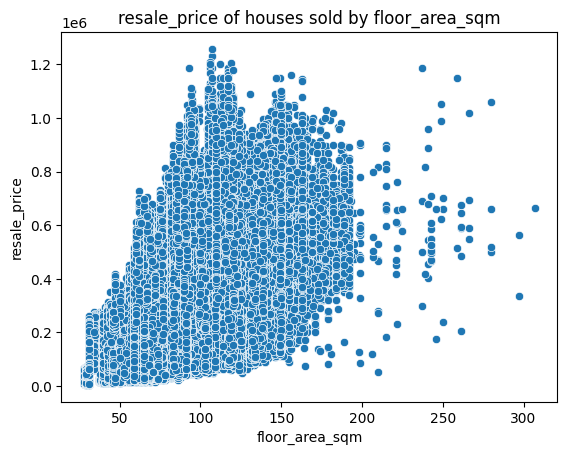

In [30]:
ax = sns.scatterplot(y="resale_price", x="floor_area_sqm", data=df.sort_values("storey_range"), legend=True)
ax.set_title("resale_price of houses sold by floor_area_sqm")

#### flat_model

popularity of flat_model has little impact on the resale_price, but flat_model can impact the minimum and maximum resale_price.

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1062/2113408113.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


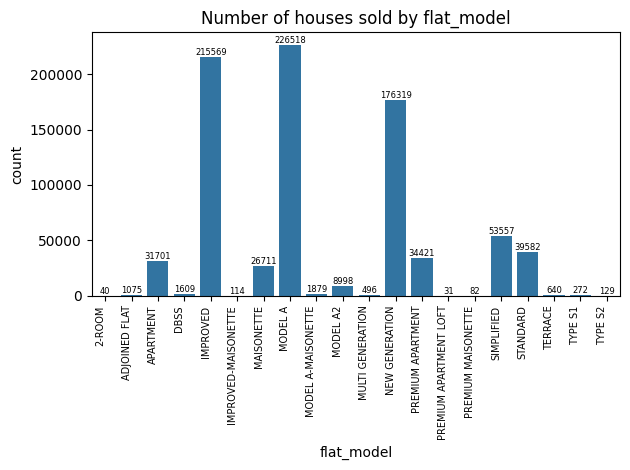

In [288]:
data = df.groupby('flat_model').size().reset_index(name='count').sort_values("flat_model")
ax = sns.barplot(y="count", x="flat_model", data=data, legend=True)
for container in ax.containers:
    ax.bar_label(container, fontsize=6)
ax.set_title("Number of houses sold by flat_model")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1062/2510928686.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


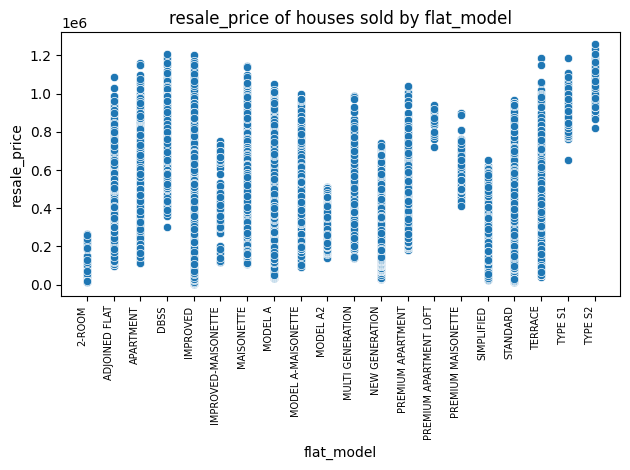

In [290]:
ax = sns.scatterplot(y="resale_price", x="flat_model", data=df.sort_values("flat_model"), legend=True)
ax.set_title("resale_price of houses sold by flat_model")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

#### lease_commence_date

houses with lease_commence_date in the 1980s have the highest number of houses sold, with newer houses being sold less. the minimum resale_price increases with lease_commence_date, indicating higher resale_prices for newer houses. 

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1062/3105411640.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


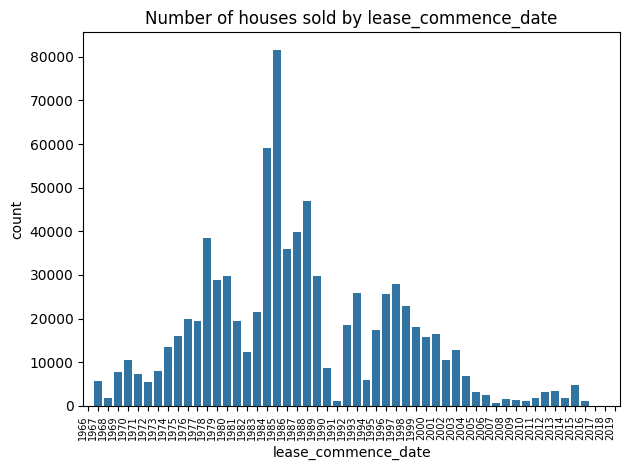

In [32]:
data = df.groupby('lease_commence_date').size().reset_index(name='count').sort_values("lease_commence_date")
ax = sns.barplot(y="count", x="lease_commence_date", data=data, legend=True)
ax.set_title("Number of houses sold by lease_commence_date")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

Text(0.5, 1.0, 'resale_price of houses sold by lease_commence_date')

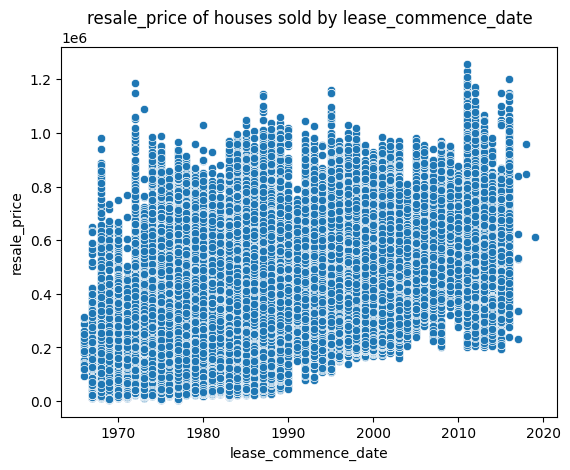

In [33]:
ax = sns.scatterplot(y="resale_price", x="lease_commence_date", data=df.sort_values("lease_commence_date"), legend=True)
ax.set_title("resale_price of houses sold by lease_commence_date")

#### remaining_lease

resale_price decreases as remaining_lease decreases.

Text(0.5, 1.0, 'resale_price of houses sold by remaining_lease')

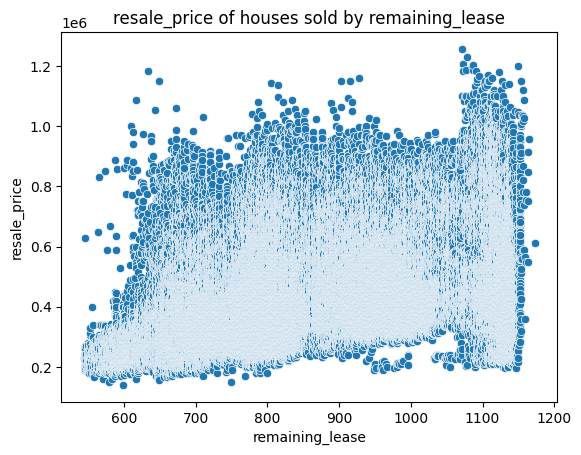

In [34]:
data = df.replace(0, np.nan).dropna(subset=['remaining_lease'])
data = data[data['remaining_lease'] != 0]
ax = sns.scatterplot(y="resale_price", x="remaining_lease", data=data.sort_values("remaining_lease"), legend=True)
ax.set_title("resale_price of houses sold by remaining_lease")

### Data Preparation

Since there is seasonality in the data, we will create a new variable "month_only" derived from "month" for the algorithm to hopefully capture seasonality based on the month.

In [52]:
df["month_only"] = df["month"].str.split("-").str[1]

In [54]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,month_only
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN,01
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN,01
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN,01
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN,01
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN,01


Split data into train and test

In [113]:
X = df.drop(columns=["resale_price"])
y = df["resale_price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [114]:
categorical_features = ["month", "month_only", "town", "flat_type", "storey_range", "flat_model", "block", "street_name"]
numerical_features = ["block", "floor_area_sqm", "lease_commence_date", "remaining_lease"]

In [142]:
# data processing for LightGBM
for c in categorical_features:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')
    X[c] = X[c].astype('category')

In [101]:
# data processing for Ridge and Lasso Regression
"""
[Remove 'block' and 'street_name']
since there can be new blocks and street names in future datasets that have not been in the data used for training, 
there will be an error when running Ridge and Lasso Regression due to one hot encoding creating new columns, these 
variables will be removed
[Replace NaN in 'remaining_lease']
since Ridge and Lasso Regression are unable to handle NaN values, and it is impossible to have a remaining lease of -1 months, 
NaN will be replaced with -1
"""
def get_ohe(df) :
    categorical_features = ["month", "month_only", "town", "flat_type", "storey_range", "flat_model"]
    df_ohe = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    df_ohe = df_ohe.drop(columns=["block", "street_name"])
    df_ohe["remaining_lease"] = df_ohe["remaining_lease"].fillna(-1)
    return df_ohe

scaler = StandardScaler()
X_train_ohe = scaler.fit_transform(get_ohe(X_train))
X_test_ohe = scaler.transform(get_ohe(X_test))

In [129]:
# save model
def save_model(filename, model) :
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# load model
def load_model(filename) :
    with open(filename, 'rb') as file:
        return pickle.load(file)

Set up evaluation metrics

Mean Absolute Error (MAE)
- a financial measure that tells on average how many dollars the model differs by
- easy interpretability for stakeholders as it quantifies a model's predictions: e.g. the model's predictions are accurate within +-$X
- robust to outliers as it treats all errors linearly, which property data often contains

R2 Score
- measures proportion of variance in dependent variable that is predictable from the independent variables, i.e. how much of the variation in housing prices is actually explained by the factors in the model
- since we need to determine the factors affecting residential property prices, a high R2 score will indicate that the features selected effectively capture the movement of the market
- normalized score allows comparison of models regardless of year due to lower and higher absolute prices


In [70]:
"""
Input: <str> model name
       <list> y test values
       <list> y predicted values
Algorithm:
- calculate mean absolute error and r2 score
"""
def evaluate_model(model_name, y_test, y_pred) :
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"""Evaluation Metrics for {model_name}
- Mean Absolute Error: {mae:,.2f}
- R2 Score: {r2:,.2f}""")

    return [mae, r2]

### Prediction using LightGBM

In [118]:
model_lgb = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1, # Uses all available CPU cores
    random_state=42
)

model_lgb.fit(X_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3182
[LightGBM] [Info] Number of data points in the train set: 549227, number of used features: 11
[LightGBM] [Info] Start training from score 292203.254321


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [130]:
"""
remove the comment and run if you want to update the model or load the model
"""
#save_model("models/lightgbm.pkl", model_lgb)
#model_lgb = load_model("models/lightgbm.pkl")

In [119]:
lgb_pred = model_lgb.predict(X_test)

In [120]:
lgb_metrics = evaluate_model("LightGBM", y_test, lgb_pred)

Evaluation Metrics for LightGBM
- Mean Absolute Error: 14,249.49
- R2 Score: 0.98


### Prediction using Ridge Regression

In [103]:
model_ridge = Ridge(alpha=1.0) # alpha is the regularization strength
model_ridge.fit(X_train_ohe, y_train)

,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


In [131]:
"""
remove the comment and run if you want to update the model or load the model
"""
#save_model("models/ridge.pkl", model_ridge)
#model_ridge = load_model("models/ridge.pkl")

In [104]:
ridge_pred = model_ridge.predict(X_test_ohe)

In [105]:
ridge_metrics = evaluate_model("Ridge Regression", y_test, ridge_pred)

Evaluation Metrics for Ridge Regression
- Mean Absolute Error: 31,079.80
- R2 Score: 0.91


In [138]:
# Analyze Ridge Coefficients
ridge_coef_df = pd.DataFrame({'Factor': X_train_ohe.columns, 'Coefficient': model_ridge.coef_})
print(ridge_coef_df.sort_values(by='Coefficient', ascending=False).head(15))

                  Factor   Coefficient
408     flat_type_5 ROOM  58231.187433
407     flat_type_4 ROOM  45820.095829
409  flat_type_EXECUTIVE  45394.873816
0         floor_area_sqm  44409.764871
373        month_only_07  28355.330871
374        month_only_08  28166.532813
376        month_only_10  27858.124260
372        month_only_06  27840.599801
375        month_only_09  27773.150684
1    lease_commence_date  27671.006928
406     flat_type_3 ROOM  26620.647743
377        month_only_11  26556.576232
369        month_only_03  25831.970769
371        month_only_05  25804.123947
370        month_only_04  25664.551148


### Prediction using Lasso Regression

In [121]:
model_lasso = Lasso(alpha=0.1, max_iter=10000) # alpha is the regularization strength
model_lasso.fit(X_train_ohe, y_train)

/Users/risalim/opt/anaconda3/envs/py11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.283e+14, tolerance: 1.210e+12
  model = cd_fast.enet_coordinate_descent(


,"alpha alpha: float, default=1.0Constant that multiplies the L1 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Lasso` object is not advised.Instead, you should use the :class:`LinearRegression` object.",0.1
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.",False
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=1000The maximum number of iterations.",10000
,"tol tol: float, default=1e-4The tolerance for the optimization: if the updates are smaller or equal to``tol``, the optimization code checks the dual gap for optimality and continuesuntil it is smaller or equal to ``tol``, see Notes below.",0.0001
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fit asinitialization, otherwise, just erase the previous solution.See :term:`the Glossary `.",False
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.",False
,"random_state random_state: int, RandomState instance, default=NoneThe seed of the pseudo random number generator that selects a randomfeature to update. Used when ``selection`` == 'random'.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"selection selection: {'cyclic', 'random'}, default='cyclic'If set to 'random', a random coefficient is updated every iterationrather than looping over features sequentially by default. This(setting to 'random') often leads to significantly faster convergenceespecially when tol is higher than 1e-4.",'cyclic'


In [132]:
"""
remove the comment and run if you want to update the model or load the model
"""
#save_model("models/lasso.pkl", model_lasso)
#model_lasso = load_model("models/lasso.pkl")

In [122]:
lasso_pred = model_lasso.predict(X_test_ohe)

In [123]:
lasso_metrics = evaluate_model("Lasso Regression", y_test, lasso_pred)

Evaluation Metrics for Lasso Regression
- Mean Absolute Error: 31,079.42
- R2 Score: 0.91


In [136]:
# Analyze Lasso Coefficients
lasso_coef_df = pd.DataFrame({'Factor': X_train_ohe.columns, 'Coefficient': model_lasso.coef_})
print(lasso_coef_df.sort_values(by='Coefficient', ascending=False).head(15))

                  Factor   Coefficient
408     flat_type_5 ROOM  58216.635893
407     flat_type_4 ROOM  45802.787031
409  flat_type_EXECUTIVE  45383.605672
0         floor_area_sqm  44411.007227
378        month_only_12  44101.471743
377        month_only_11  42159.634786
376        month_only_10  40443.614475
375        month_only_09  36916.664210
374        month_only_08  35521.553634
373        month_only_07  33030.154452
372        month_only_06  29493.054509
1    lease_commence_date  27670.751374
406     flat_type_3 ROOM  26604.939274
371        month_only_05  26581.627200
370        month_only_04  24366.528828


### Model Evaluation

Out of the three models tested, LightGBM performed the best with the lowest MAE and highest R2 score. Using 5 fold cross validation for hyperparameter tuning, the best parameters for LightGBM are: 

Best Parameters: {'subsample': 0.7, 'num_leaves': 127, 'n_estimators': 1000, 'min_child_samples': 50, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


Both the MAE and R2 scores have improved after tuning.

In [291]:
model_scores = {"LightGBM": lgb_metrics,
                "Ridge Regression": ridge_metrics,
                "Lasso Regression": lasso_metrics}
pd.DataFrame(model_scores, index=["MAE", "R2 Score"])

,LightGBM,Ridge Regression,Lasso Regression
MAE,14249.490480,31079.796121,31079.419743
R2 Score,0.978719,0.912922,0.912923


In [292]:
"""
** DO NOT RE RUN **
5 fold cross validation for lightgbm
"""

param_distributions = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=model_lgb,
    param_distributions=param_distributions,
    n_iter=10, 
    scoring='neg_mean_absolute_error', # Optimized for MAE
    cv=kf,
    verbose=1,
    random_state=42,
    n_jobs=-1 # Uses all available CPU cores
)

print("Starting Hyperparameter Tuning...")
random_search.fit(X, y)

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/risalim/opt/anaconda3/envs/py11/lib/python3.11/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 180, in <module>
    exitcode = process_obj._bootstrap()
  File "/Users/risalim/opt/anaconda3/envs/py11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/risalim/opt/anaconda3/envs/py11/lib/python3.11/multiprocessing/process.py", line 108, in

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LGBMRegressor...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.7, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [-1, 10, ...], 'min_child_samples': [20, 50, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_mean_absolute_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strate

In [294]:
print(f"Best Parameters: {random_search.best_params_}")

Best Parameters: {'subsample': 0.7, 'num_leaves': 127, 'n_estimators': 1000, 'min_child_samples': 50, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [295]:
best_model = random_search.best_estimator_
lgb_tuned_pred = best_model.predict(X_test)
lgb_tuned_metrics = evaluate_model("LightGBM Tuned", y_test, lgb_tuned_pred)

Evaluation Metrics for LightGBM Tuned
- Mean Absolute Error: 10,910.05
- R2 Score: 0.99


In [297]:
"""
remove the comment and run if you want to update the model or load the model
"""
#save_model("models/lightgbm_tuned.pkl", best_model)
#model_lasso = load_model("models/lightgbm_tuned.pkl")

'\nremove the comment and run if you want to update the model or load the model\n'

In [298]:
model_scores = {"LightGBM": lgb_metrics,
                "LightGBM Tuned": lgb_tuned_metrics}
pd.DataFrame(model_scores, index=["MSE", "R2 Score"])

,LightGBM,LightGBM Tuned
MSE,14249.490480,10910.051340
R2 Score,0.978719,0.988173


### Insights

Based on the feature importance using LightGBM, we can come up with strategies to curb housing prices inflation.

The top 5 features can be categorised into the following:

- Location: based on block, street_name, town
- Time: based on month
- Floor Area: based on floor_area_sqm

Based on these 3 categories, we can come up with a strategy to curb housing prices inflation.

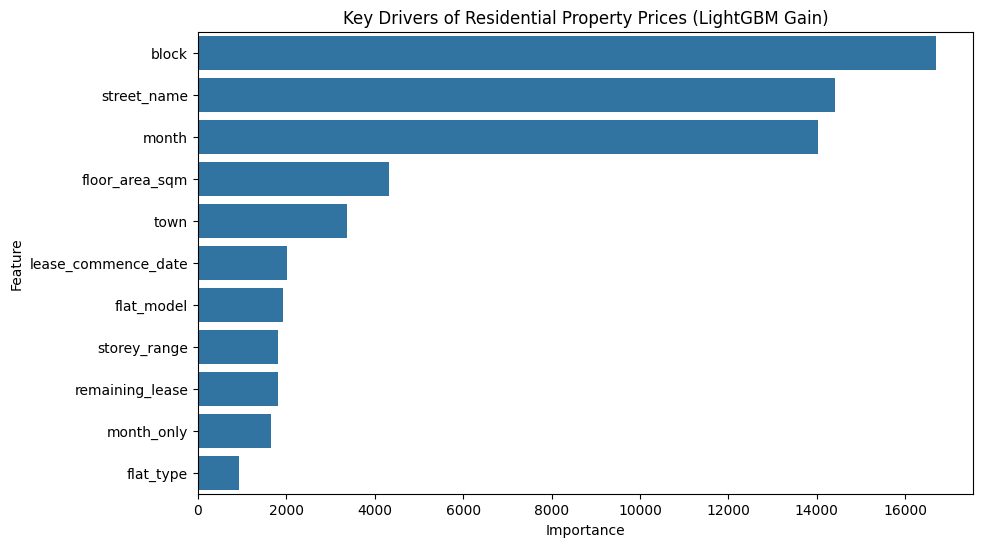

In [164]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Key Drivers of Residential Property Prices (LightGBM Gain)')
plt.show()

# Model Prediction Task II

1. Data Governance

    Viewing the data from the past 30 years, there has been some data inconsistencies.
    - remaining_lease being introduced later starting with year and changing into years and months after. Converting this into a single numerical feature of months is critical to ensure the model is able to capture lease decay accurately. 
    - storey_range from 2012 to 2014 had inconsistent entries that were not part of the standard bins. To ensure predicitions will not be skewed by inconsistent entries, a deeper look into how this variable was captured should be investigated. This can be resolved by provided a set number of categories of storey_ranges to pick from. 
<br><br>
2. Resource Constraints and Collaboration

    This scenario mentions that colleagues do not have GPU access, restricting the choices of algorithms based on their ability to run on local CPU isntead of what might be the best fit to predict prices.
    - Deep learning algorithms like neural networks often require GPU while LightGBM, Ridge and Lasso Regression are able to run efficiently on CPUs which is why they were used in this scenario.
    - Hosting jupyter notebook on cloud would ensure anyone can run the code without complex environment setups locally and that everyone can see each others code changes.
    - Continuous Integration and Continous Deployment: Github/Bitbucket can be used to maintain code health through versioning since multiple colleagues can edit, preventing code conflicts.
<br><br>
3. Feature Selection

    To determine the factors affecting inflation, the features generated and selected are important.
    - month allows the model to measure systemic inflation while month_only is a seasonal feature that helps to identify cyclical demand surgers
    - categorical variables like town, storey_range, month, monthly_only, flat_type and flat_model need to undergo one-hot encoding to allow easily interpretable model results. For example, the reporting officer can see the specific price premium of a town using the model's coefficients.
    - there are other potential important features not captured by the data that might be instrumental in predicting property prices
        - previous property: are buyers downgrading or upgrading their flats?
        - number of people: are buyers paying higher for floor area because they need the space?
<br><br>
4. Model Intepretability

    Since not all users are technically trained, it is important that they are able to understand the model results to come up with insights for policy making.
    - LightGBM's feature importance (gain) allows us to quanitify exactly how much a dependent variable contributes to price, allowing the direct comparison of variables and which to focus on to best curb price inflation.
    - Ridge and Lasso Regression alongside LightGBM provides coefficients easily explainable, quanitfying the impact of each variable. E.g. every additional floor level adds approximately $3000 to its price.
<br><br>
5. Evaluation Metrics

    Since we are interested in curbing price inflation, the evaluation metric must be based on this. 
    - Mean squared error is best for curbing inflation as it penalizes large errors and forces the model to be more sensitive to outliers (i.e. extremely high prices) that often signal the start of inflation.
    - R2 score identifies and validates the features that are true drivers of price. Since our R2 score is 0.99, this means all features used explain 99% of the price, then policies targeting these attributes will likely be effective.
<br><br>
6. Strategies

    Based on the R2 score, we can build strategies for each feature to curb price inflation. The top 5 features can be categorised into the following:
    - Location: based on block, street_name, town
    - Time: based on month
    - Floor Area: based on floor_area_sqm

    Location
    - During EDA, it was noted that some towns are more popular than others and thus have different maximum resale_prices by town.
    - Location being an important feature indicates that price inflation is being driven by localised demand in popular towns rather than a general nationwide increase.
    - Strategy: zoning cooling measures to target popular towns. By introducing a location specific surcharge or tighter loan to value, the additional costs might be enough to reduce demand in popular areas and push buyers to look at other more affordable towns instead since the perceived value drops. 

    Time
    - During EDA, it was noted that there is seasonality, with prices peaking in July.
    - Time being an important feature indicates that prices inflate and lull depending on the month.
    - Strategy: synchronize Build-To-Order (BTO) launch dates to precede peak months identified by the model. By pre-saturating the market with supply just before high-demand periods, the government can smooth out the annual price curve.

    Floor Area
    - During EDA, it was noted that for lower floor_area_sqm, resale_price is almost guaranteed to be lower but for higher floor_area_sqm, the resale_price ranges from low to high. 
    - Floor area being an important feature indicates that price inflation is being driven by demand for more space and the willingness to pay more drives up prices for larger floor area space.
    - Strategy: since older flats have bigger floor areas and there is a demand for more space, pivot BTO launches to include a higher percentage of bigger units to encourage BTOs instead of resales, therefore reducing the demand and thus curbing price inflation. Over time, this will also increase the supply of large units and eventually reduce the scarcity premium currently being paid in the resale market.

# Link Analysis Task I

To analyze relationships between each property listing, a schema identifying micro-markets will be created. In a predictive context, a property's price is highly dependent on its neighbours and this graph will help to visualize clusters of similar transactions which are usually more price stable than isolated nodes. Since there are 80374 records from January 2017, sampling must be done to reduce computational complexity and clearer visualisation as multiple nodes and connections will just appear as a solid mass of colour. Stratified sampling will be used to ensure the same proportion of key categories like town and flat_type are maintained, especially imporatnt for under-represented categories which can lead to biased insights. We will sample 820, about 0.1% of the original data.

| Component      | Variable | Reasoning |
| :---        |    :----   |   :----   |
|Nodes|Individual Property Listings|Each node represents a unique transaction|
|Edges|Linked if same street_name and flat_type|Units on the same street and of the same type are direct competitors and thus prices pegged to each other|
|Node Colour|Town|Allows identification of interconnected towns|
|Node Size|Resale Price|Higher resale prices have larger nodes, easily identifying price outliers within a cluser|

In [231]:
df_2017 = df.loc[df["month"]>="2017-01"].reset_index(drop=True)
df_2017.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,month_only
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,IMPROVED,1979,232000.0,0.0,01
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,NEW GENERATION,1978,250000.0,0.0,01
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,NEW GENERATION,1980,262000.0,0.0,01
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,NEW GENERATION,1980,265000.0,0.0,01
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,NEW GENERATION,1980,265000.0,0.0,01


In [239]:
# stratified sampling

def robust_sample(group):
    # Calculate 0.1% of the total dataset proportion for this group
    # We use a higher fraction here because we are sampling from the 2017 subset 
    # to reach the ~820 node target relative to the 820k total rows.
    n = int(len(group) * 0.005) 
    return group.sample(max(n, 1), random_state=42)

df_2017_sample = df_2017.groupby(['town', 'flat_type'], group_keys=False).apply(robust_sample)
df_2017_sample = df_2017_sample.reset_index(drop=True)

# 3. Automated Color Mapping for Towns
unique_towns = sorted(df_2017_sample['town'].unique())
# Use tab20 colormap for distinct colors across Singapore's towns
color_palette = cm.get_cmap('tab20', len(unique_towns))
town_colors = {town: color_palette(i) for i, town in enumerate(unique_towns)}

print(f"Final Stratified Sample Size: {len(df_2017_sample)}")

# Verify that the distribution remains the same
print(df['town'].value_counts(normalize=True).head())
print(df_2017_sample['town'].value_counts(normalize=True).head())

Final Stratified Sample Size: 395
town
TAMPINES       0.088613
YISHUN         0.076675
BEDOK          0.074432
JURONG WEST    0.073413
WOODLANDS      0.070848
Name: proportion, dtype: float64
town
SENGKANG       0.078481
JURONG WEST    0.073418
WOODLANDS      0.073418
YISHUN         0.070886
TAMPINES       0.065823
Name: proportion, dtype: float64


/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1062/3213363821.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_2017_sample = df_2017.groupby(['town', 'flat_type'], group_keys=False).apply(robust_sample)
/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1062/3213363821.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap('tab20', len(unique_towns))


In [240]:
G = nx.Graph()
for i, row in df_2017_sample.iterrows() :
    G.add_node(i, town=row['town'], price=row['resale_price'], type=row['flat_type'])

# Connect nodes if they are on the same street and have the same flat type
for _, group in df_2017_sample.groupby(['street_name', 'flat_type']):
    indices = group.index.tolist()
    # Connect every listing on this street of this type to each other
    for i in range(len(indices)):
        for j in range(i + 1, len(indices)):
            G.add_edge(indices[i], indices[j])

Text(0.5, 1.0, 'Market Relationship Graph from Jan 2017')

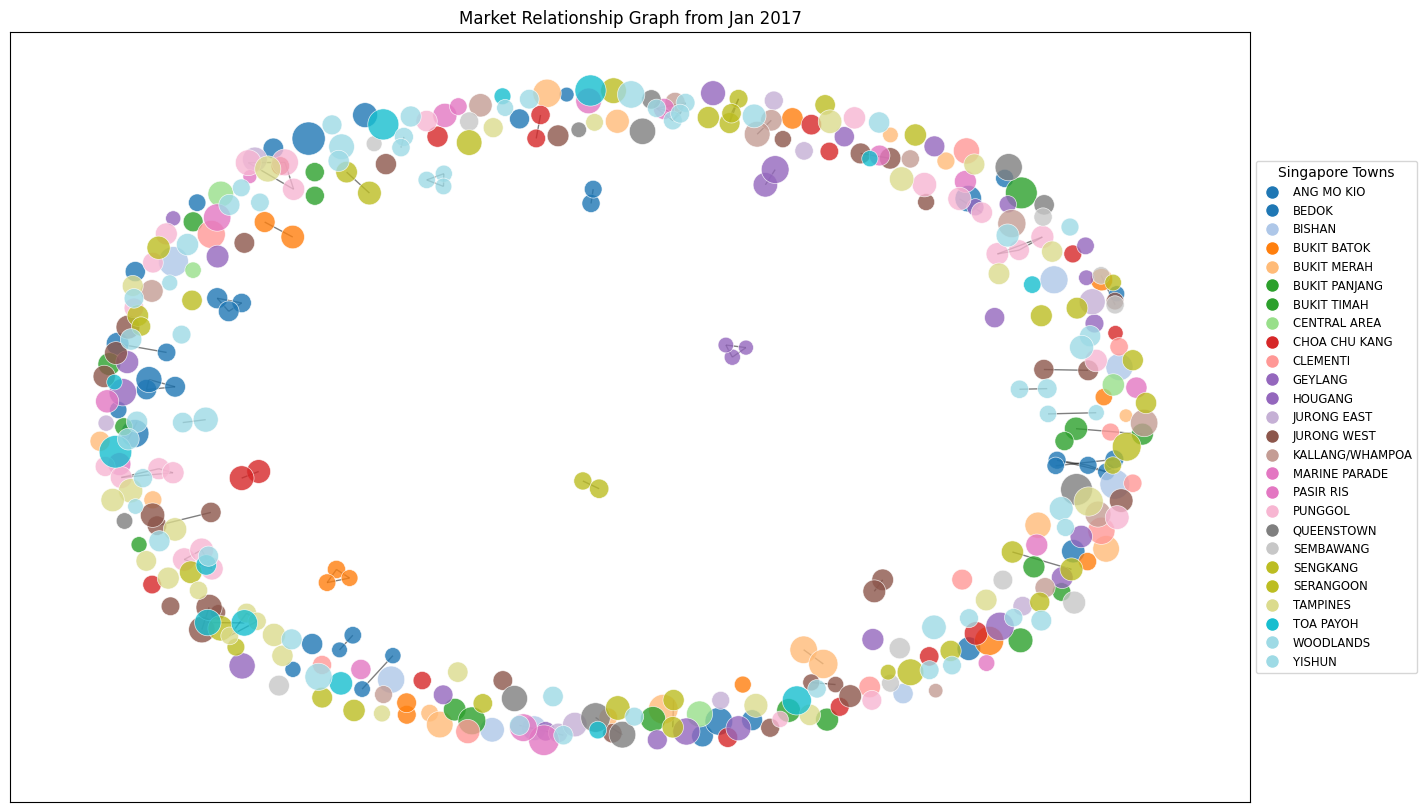

In [245]:
plt.figure(figsize=(16, 10))
pos = nx.spring_layout(G, k=0.12, iterations=50, seed=42)

node_color_list = [town_colors[G.nodes[n]['town']] for n in G.nodes()]
node_size_list = [G.nodes[n]['price'] / 1800 for n in G.nodes()] # Scaled for visibility

nx.draw_networkx_nodes(G, pos, node_size=node_size_list, node_color=node_color_list, alpha=0.8, edgecolors='white', linewidths=0.5)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='black')
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=town,
           markerfacecolor=town_colors[town], markersize=10)
    for town in unique_towns
]

# Position the legend outside the main plot area for clarity
plt.legend(handles=legend_elements, title="Singapore Towns", 
           loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=1)
plt.title("Market Relationship Graph from Jan 2017")

High-level analysis of graph components

Connected Components
- Observation: Large tightly knit clusters of single colours (e.g. Punggol and Ang Mo Kio) 
- Insight: These clusters are price setters as many similar units are sold in close proximity
- Strategy: Implementing a price monitoring alert in high density clusters can allow for early intervention before the entire cluster increases in price. To curb inflation, focus on setting a price ceiling for clusters to prevent extremely high prices that can lead to inflation.

Isolated Nodes
- Observation: Nodes with no edges represent unique listings with no comparable street and flat type
- Insight: These are risky because without a local price setter, there is no real logic to setting a price and the seller can set any arbitrary price. 
- Strategy: Implementing enhanced valuation checks for isolated flats will prevent artifically high prices that can influence wider town inflation.

Bridge Nodes
- Observation: Nodes that sit between major clusters or connect to slightly different models in the same town
- Insight: These flats are the second choices should the buyer not be able to afford a unit in the popular major cluster. 
- Strategy: Take advantage of these flats to smooth demand for the major clusters by redirecting buyers through directed grants to these less popular clusters, reducing pressure and price driving of popular clusters. 

Based on the LightGBM features and this Link Analysis graph, the strategy for town specific zoning cooling measures would be most effective to restrict the prices. 

# Link Analysis Task II

To identify price anchors and large clusters, the algorithms used will be Degree Centrality and Connected Components. 

### Degree Centrality

- measures the number of direct edges connected to a single node (i.e. how many comparable flats with the same street names and flat types)
- nodes with high degree centrality are the most price anchored properties
- results:

    | town      | street_name | flat_type | centrality_score |
    | :---        |    :----   |   :----   |  :----   |
    |YISHUN   |   YISHUN RING RD  |  4 ROOM      |    0.007614|
    |GEYLANG   |       CIRCUIT RD  |  3 ROOM      |    0.005076|
    |SENGKANG   |   RIVERVALE CRES  |  4 ROOM     |     0.005076|
    |BEDOK     |   BEDOK NTH RD  |  4 ROOM       |   0.005076|
    |BEDOK | BEDOK RESERVOIR RD  |  4 ROOM       |   0.005076|
    
    <br>
    
- strategy: to curb inflation, implement alerts for high degree nodes because of their centrality, a high price is likely to trigger the rest of the town setting similar high prices, leading to the entire town's prices inflating. Referencing the results above, the general town alerts can include Yishun, Geylang, Senkang and Bedok while the specific street name alerts can include Yishun Ring Rd, Circuit Rd, Rivervale Cres, Bedok Nth Rd and Bedok Reservoir Rd.



In [247]:
deg_centrality = nx.degree_centrality(G)
centrality_df = pd.DataFrame({
    'node_id': deg_centrality.keys(),
    'centrality_score': deg_centrality.values()
})
centrality_df

,node_id,centrality_score
0,0,0.000000
1,1,0.005076
2,2,0.000000
3,3,0.002538
4,4,0.005076
...,...,...
390,390,0.000000
391,391,0.000000
392,392,0.000000
393,393,0.000000


In [254]:
anchors = centrality_df.sort_values(by='centrality_score', ascending=False).head(10)
anchors_info = anchors.merge(df_2017_sample, left_on='node_id', right_index=True)

print("Top 5 Market Anchors (High Degree Centrality):")
print(anchors_info[['town', 'street_name', 'flat_type', 'centrality_score']].drop_duplicates())

Top 5 Market Anchors (High Degree Centrality):
         town         street_name flat_type  centrality_score
375    YISHUN      YISHUN RING RD    4 ROOM          0.007614
123   GEYLANG          CIRCUIT RD    3 ROOM          0.005076
274  SENGKANG      RIVERVALE CRES    4 ROOM          0.005076
28      BEDOK        BEDOK NTH RD    4 ROOM          0.005076
29      BEDOK  BEDOK RESERVOIR RD    4 ROOM          0.005076


### Connected Components
- identifies clusters where every node is reachable from any other node in the cluster (i.e. clusters of similar properties on the same street)
- large components have more data points and prices tend to be similar 
- results:

    | size      | town | street name | flat type |
    | :---        |    :----   |   :----   |  :----   |
    |4     | YISHUN          | YISHUN RING RD            | 4 ROOM|
    |3     | ANG MO KIO      | ANG MO KIO AVE 3          | 3 ROOM|
    |3     | BEDOK           | BEDOK RESERVOIR RD        | 4 ROOM|
    |3     | BEDOK           | BEDOK NTH RD              | 4 ROOM|
    |3     | BUKIT BATOK     | BT BATOK WEST AVE 8       | 3 ROOM|
    |3     | GEYLANG         | CIRCUIT RD                | 3 ROOM|
    |3     | PUNGGOL         | EDGEFIELD PLAINS          | 4 ROOM|
    |3     | PUNGGOL         | PUNGGOL FIELD             | 4 ROOM|
    |3     | PUNGGOL         | PUNGGOL PL                | 4 ROOM|
    |3     | PUNGGOL         | PUNGGOL DR                | 5 ROOM|
    |3     | SENGKANG        | RIVERVALE CRES            | 4 ROOM|
    |3     | TAMPINES        | TAMPINES ST 21            | 3 ROOM|
    |3     | YISHUN          | YISHUN ST 11              | 3 ROOM|
    
    <br>    
- strategy: to curb inflation, introduce cooling measures in large connected components as high volume of similar sales can lead to bidding wars that rapidly increase prices and lead to the entire town's prices inflating.

Referencing the results above, cooling measures can be implemented in the towns: Yishun, Ang Mo Kio, Bedok, Bukit Batok, Geyland, Punggol, Sengkang and Tampines since they are the most significant price setters. 


In [249]:
components = list(nx.connected_components(G))
comp_sizes = [len(c) for c in components]

In [267]:
print(f"\nTotal Number of Micro-Markets (Components): {len(components)}")
print(f"Largest Micro-Market Size: {max(comp_sizes)} listings")
print(f"Average Micro-Market Size: {np.mean(comp_sizes):.2f} listings")
high_activity_hubs = [c for c in components if len(c) >= 3]
high_activity_hubs.sort(key=len, reverse=True)
print(f"Found {len(high_activity_hubs)} hubs with 3 or more listings.\n")
print(f"{'Size':<5} | {'Town':<15} | {'Street Name':<25} | {'Flat Type'}")
print("-" * 65)
for nodes in high_activity_hubs:
    rep_idx = list(nodes)[0]
    row = df_2017_sample.iloc[rep_idx]
    print(f"{len(nodes):<5} | {row['town']:<15} | {row['street_name']:<25} | {row['flat_type']}")


Total Number of Micro-Markets (Components): 336
Largest Micro-Market Size: 4 listings
Average Micro-Market Size: 1.18 listings
Found 13 hubs with 3 or more listings.

Size  | Town            | Street Name               | Flat Type
-----------------------------------------------------------------
4     | YISHUN          | YISHUN RING RD            | 4 ROOM
3     | ANG MO KIO      | ANG MO KIO AVE 3          | 3 ROOM
3     | BEDOK           | BEDOK RESERVOIR RD        | 4 ROOM
3     | BEDOK           | BEDOK NTH RD              | 4 ROOM
3     | BUKIT BATOK     | BT BATOK WEST AVE 8       | 3 ROOM
3     | GEYLANG         | CIRCUIT RD                | 3 ROOM
3     | PUNGGOL         | EDGEFIELD PLAINS          | 4 ROOM
3     | PUNGGOL         | PUNGGOL FIELD             | 4 ROOM
3     | PUNGGOL         | PUNGGOL PL                | 4 ROOM
3     | PUNGGOL         | PUNGGOL DR                | 5 ROOM
3     | SENGKANG        | RIVERVALE CRES            | 4 ROOM
3     | TAMPINES        | TAMPI